# Synthetic Streamflow Diagnostic Figure Library

The following functions can be used to compare the following properties of historic and synthetic streamflow:
- Flow magnitude
- Non-exceedance probabilities (flow duration curves)
- Autocorrelation
- Spatial correlation across locations

## Diagnostic plotting functions

- `plot_flow_ranges()`
	- Range and median of flow values in historic and synthetic flow timeseries.
- `plot_fdc_ranges()`
	- The range of annual flow duration curves (FDCs) for historic and synthetic streamflow timeseries.
- `plot_autocorrelation()`
	- Comparison of historic and synthetic autocorrelation across a range of lag values.
- `plot_spatial_correlation()`
	- Heatmap visualizations of Pearson correlation between different flow locations in the historic data and a single synthetic realization.

These functions are designed to accept historic (`Qh`) and synthetic (`Qs`) data with the following properties:
- `Qh` : A pd.Series containing a single historic streamflow timeseries. The index of this data must be type pd.DatetimeIndex.

- `Qs` : A pd.DataFrame containing many synthetic streamflow timeseries. The columns should each contain a single synthetic realization and the index must be type pd.DatetimeIndex. The column names do not matter.

Additionally, each function (excluding `plot_fdc_ranges()`) has a `timestep` keyword argument which changes the temporal scale of the flow being considered. Options are 'daily', 'weekly', or 'monthly', and the `pandas.groupby()` function is used to aggregate data accordingly to allow for comparison of statistics at different temporal scales. The default is 'daily'. 

## Streamflow data

The historic data used in this example is taken from the Delaware River Basin. Specifically, streamflow data from the [USGS gauge at Lordville, NY,](https://waterdata.usgs.gov/monitoring-location/01427207/#parameterCode=00065&period=P7D) on the upper portion of the Delaware River is used. 

The synthetic streamflow was generated using the Kirsch-Nowak [2, 3] synthetic streamflow generator. For more detail on this generator, see Julie's post here: [Open Source Streamflow Generator Part 1.](https://waterprogramming.wordpress.com/2017/08/29/open-source-streamflow-generator-part-i-synthetic-generation/)

I created 100 synthetic realizations of 30-year, daily streamflow timeseries at the Lordville gauge.

The historic and synthetic streamflow timeseries are assumed to start at the same date. Most of the plotting functions below do not explicitly consider the date associated with the timeseries, however comparisons between flow statistics across some range of time assume that the timeseries are aligned for the same dates. 
***


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# Load and prepare the data
Qs = pd.read_csv('./example_data/synthetic_streamflow_100_realizations_delLordville.csv', sep=',', index_col=0, parse_dates=True)

Qh_df = pd.read_csv(f'./example_data/gage_flow_obs_pub.csv', sep=',', index_col=0, parse_dates=True).loc['1984-01-01':, :]
Qh = Qh_df['delLordville']

## Flow magnitude range

This first plot simply shows the range (max, min) and median of flows for both historic and synthetic datasets.

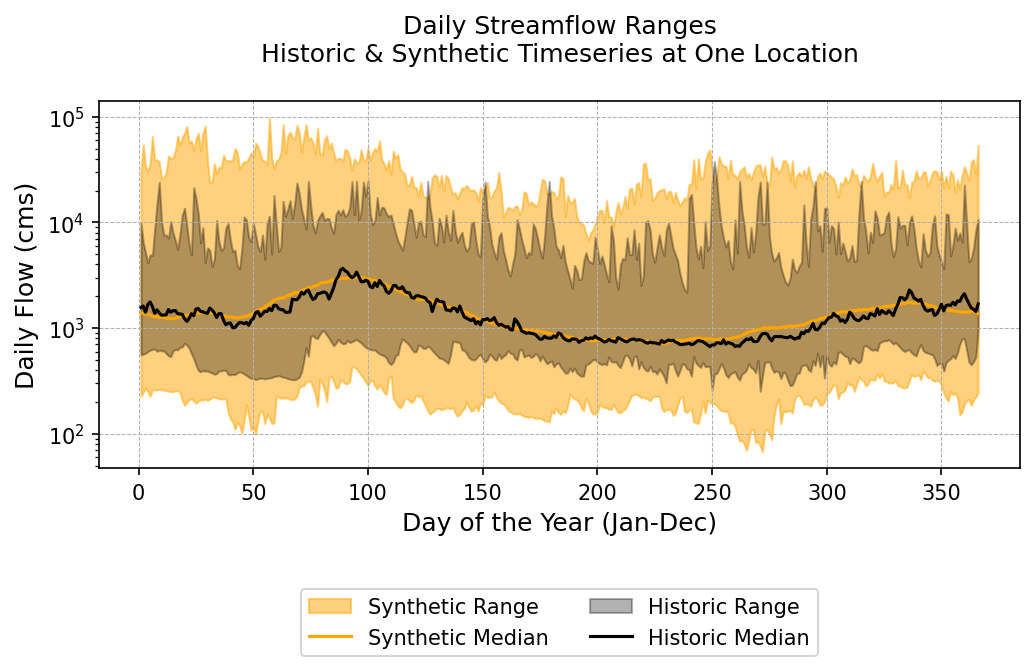

In [2]:
def plot_flow_ranges(Qh, Qs, 
                     timestep = 'daily',
                     units = 'cms', y_scale = 'log',
                     savefig = False, fig_dir = '.',
                     figsize = (7,5), colors = ['black', 'orange'],
                     title_addon = ""):
    """Plots the range of flow for historic and syntehtic streamflows for a specific timestep scale.
    
    Args:
        Qh (pd.Series): Historic daily streamflow timeseries. Index must be pd.DatetimeIndex. 
        Qs (pd.DataFrame): Synthetic daily streamflow timeseries realizations. Each column is a unique realization. Index must be pd.DatetimeIndex.
        timestep (str, optional): The timestep which data should be aggregated over. Defaults to 'daily'. Options are 'daily', 'weekly', or 'monthly'.
        units (str, optional): Streamflow units, for axis label. Defaults to 'cms'.
        y_scale (str, optional): Scale of the y-axis. Defaults to 'log'.
        savefig (bool, optional): Allows for png to be saved to fig_dir. Defaults to False.
        fig_dir (str, optional): Location of saved figure output. Defaults to '.' (working directory).
        figsize (tuple, optional): The figure size. Defaults to (4,4).
        colors (list, optional): List of two colors for historic and synthetic data respectively. Defaults to ['black', 'orange'].
        title_addon (str, optional): Text to be added to the end of the title. Defaults to "".
    """


    # Assert formatting matches expected
    assert(type(Qh.index) == pd.DatetimeIndex), 'Historic streamflow (Qh) should have pd.DatatimeIndex.'
    assert(type(Qs.index) == pd.DatetimeIndex), 'Synthetic streamflow (Qh) should have pd.DatatimeIndex.'

    # Handle conditional datetime formatting
    if timestep == 'daily':
        h_grouper = Qh.index.dayofyear
        s_grouper = Qs.index.dayofyear
        x_lab = 'Day of the Year (Jan-Dec)'
    elif timestep == 'monthly':
        h_grouper = Qh.index.month
        s_grouper = Qs.index.month
        x_lab = 'Month of the Year (Jan-Dec)'
    elif timestep == 'weekly':
        h_grouper = pd.Index(Qh.index.isocalendar().week, dtype = int)
        s_grouper = pd.Index(Qs.index.isocalendar().week, dtype = int)
        x_lab = 'Week of the Year (Jan-Dec)'
    else:
        print('Invalid timestep input. Options: "daily", "monthly", "weekly".')
        return

    # Find flow ranges
    s_max = Qs.groupby(s_grouper).max().max(axis=1)
    s_min = Qs.groupby(s_grouper).min().min(axis=1)
    s_median = Qs.groupby(s_grouper).median().median(axis=1)
    h_max = Qh.groupby(h_grouper).max()
    h_min = Qh.groupby(h_grouper).min()
    h_median = Qh.groupby(h_grouper).median()
  
    ## Plotting  
    fig, ax = plt.subplots(figsize = figsize, dpi=150)
    xs = h_max.index
    ax.fill_between(xs, s_min, s_max, color = colors[1], label = 'Synthetic Range', alpha = 0.5)
    ax.plot(xs, s_median, color = colors[1], label = 'Synthetic Median')
    ax.fill_between(xs, h_min, h_max, color = colors[0], label = 'Historic Range', alpha = 0.3)
    ax.plot(xs, h_median, color = colors[0], label = 'Historic Median')
    
    ax.set_yscale(y_scale)
    ax.set_ylabel(f'{timestep.capitalize()} Flow ({units})', fontsize=12)
    ax.set_xlabel(x_lab, fontsize=12)

    ax.legend(ncols = 2, fontsize = 10, bbox_to_anchor = (0, -.5, 1.0, 0.2), loc = 'upper center')    
    ax.grid(True, linestyle='--', linewidth=0.5)
    ax.set_title(f'{timestep.capitalize()} Streamflow Ranges\nHistoric & Synthetic Timeseries at One Location\n{title_addon}')
    plt.tight_layout()
    
    if savefig:
        plt.savefig(f'{fig_dir}/flow_ranges_{timestep}.png', dpi = 150)
    return

## Usage
plot_flow_ranges(Qh, Qs, timestep='daily', savefig=False)

This figure provides a lot of useful information about our synthetic ensemble:

- The synthetic ensembles envelope the limited historic values, and include more extreme high and low flows
- The seasonal trends in the synthetics align with the historic
- The median of the synthetic ensemble aligns very closely with the median of the historic data.

### Flow duration curve ranges

The `plot_fdc_ranges()` function will calculate an FDC for each year of the historic and synthetic data, and plot the ranges that these FDCs take. It will also "total" FDCs calculated for the entirety of the historic or synthetic records.

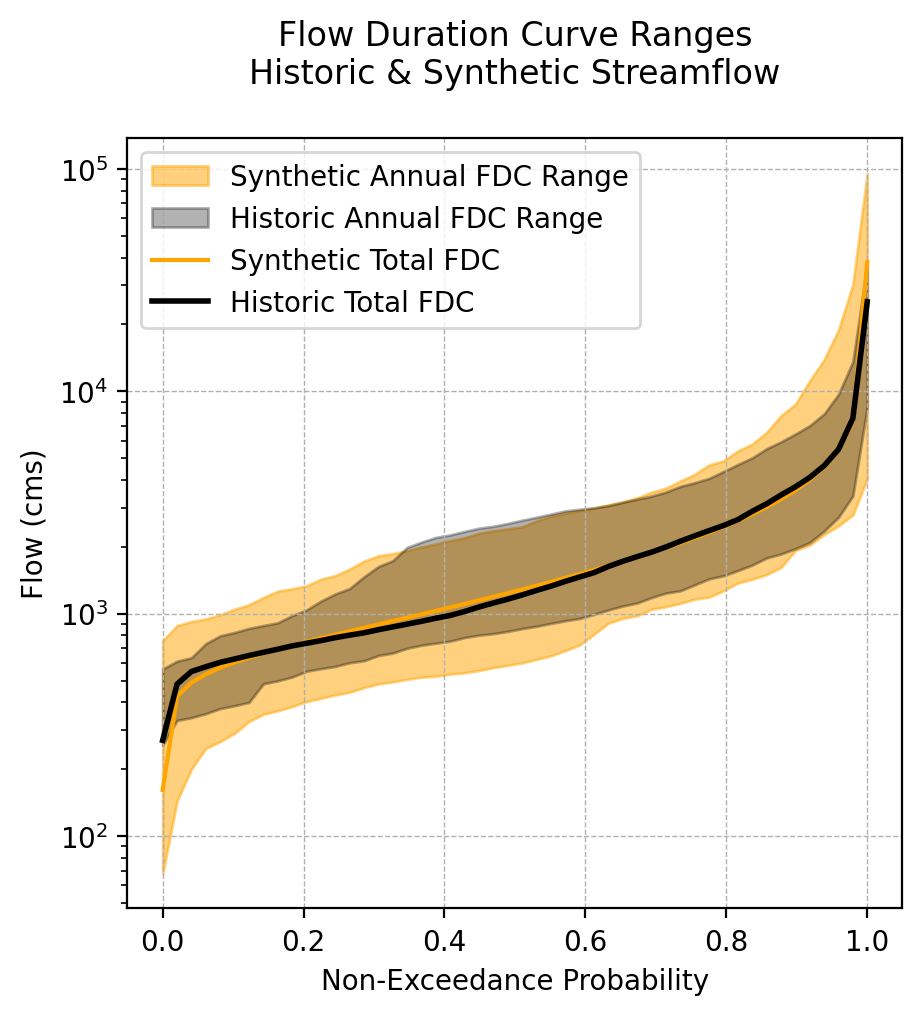

In [3]:
def plot_fdc_ranges(Qh, Qs, 
                    units = 'cms', y_scale = 'log',
                    savefig = False, fig_dir = '.',
                    figsize = (5,5), colors = ['black', 'orange'],                   
                    title_addon = ""):
    """Plots the range and aggregate flow duration curves for historic and synthetic streamflows.
    
    Args:
        Qh (pd.Series): Historic daily streamflow timeseries. Index must be pd.DatetimeIndex. 
        Qs (pd.DataFrame): Synthetic daily streamflow timeseries realizations. Each column is a unique realization. Index must be pd.DatetimeIndex.
        units (str, optional): Streamflow units, for axis label. Defaults to 'cms'.
        y_scale (str, optional): Scale of the y-axis. Defaults to 'log'.
        savefig (bool, optional): Allows for png to be saved to fig_dir. Defaults to False.
        fig_dir (str, optional): Location of saved figure output. Defaults to '.' (working directory).
        figsize (tuple, optional): The figure size. Defaults to (4,4).
        colors (list, optional): List of two colors for historic and synthetic data respectively. Defaults to ['black', 'orange'].
        title_addon (str, optional): Text to be added to the end of the title. Defaults to "".
    """
    
    ## Assertions
    assert(type(Qs) == pd.DataFrame), 'Synthetic streamflow should be type pd.DataFrame.'
    assert(type(Qh.index) == pd.DatetimeIndex), 'Historic streamflow (Qh) should have pd.DatatimeIndex.'
    assert(type(Qs.index) == pd.DatetimeIndex), 'Synthetic streamflow (Qh) should have pd.DatatimeIndex.'

    
    # Calculate FDCs for total period and each realization
    nonexceedance = np.linspace(0.0001, 0.9999, 50)
    s_total_fdc = np.quantile(Qs.values.flatten(), nonexceedance)
    h_total_fdc = np.quantile(Qh.values.flatten(), nonexceedance) 
    
    s_fdc_max = np.zeros_like(nonexceedance)
    s_fdc_min = np.zeros_like(nonexceedance)
    h_fdc_max = np.zeros_like(nonexceedance)
    h_fdc_min = np.zeros_like(nonexceedance)

    annual_synthetics = Qs.groupby(Qs.index.year)
    annual_historic = Qh.groupby(Qh.index.year)

    for i, quant in enumerate(nonexceedance):
            s_fdc_max[i] = annual_synthetics.quantile(quant).max().max()
            s_fdc_min[i] = annual_synthetics.quantile(quant).min().min()
            h_fdc_max[i] = annual_historic.quantile(quant).max()
            h_fdc_min[i] = annual_historic.quantile(quant).min()
    
    ## Plotting
    fig, ax = plt.subplots(figsize=figsize, dpi=200)
    
    #for quant in syn_fdc_quants:
    ax.fill_between(nonexceedance, s_fdc_min, s_fdc_max, color = colors[1], label = 'Synthetic Annual FDC Range', alpha = 0.5)
    ax.fill_between(nonexceedance, h_fdc_min, h_fdc_max, color = colors[0], label = 'Historic Annual FDC Range', alpha = 0.3)

    ax.plot(nonexceedance, s_total_fdc, color = colors[1], label = 'Synthetic Total FDC', alpha = 1)
    ax.plot(nonexceedance, h_total_fdc, color = colors[0], label = 'Historic Total FDC', alpha = 1, linewidth = 2)

    ax.grid(True, linestyle='--', linewidth=0.5)
    ax.set_yscale(y_scale)
    ax.set_ylabel(f'Flow ({units})')
    ax.set_xlabel('Non-Exceedance Probability')
    ax.legend(fontsize= 10)
    ax.grid(True, linestyle='--', linewidth=0.5)
    
    plt.title(f'Flow Duration Curve Ranges\nHistoric & Synthetic Streamflow\n{title_addon}')
    if savefig:
        plt.savefig(f'{fig_dir}/flow_duration_curves_{title_addon}.png', dpi=200)
    plt.show()
    return

## Usage 
plot_fdc_ranges(Qh, Qs.iloc[:,0:30], savefig = False)

Similar to the flow range plot above, we see that the synthetic ensemble is nicely enveloping the historic data; there are synthetic instances where the extreme flows in a particular year are more extreme than historic observations. However, the FDC of the total synthetic ensemble (if all synthetics were combined) is almost exactly equal to the total historic FDC.

## Autocorrelation

Hydrologic systems are known to have memory, or correlation between streamflow at different points in time. We want to make sure that our synthetic streamflow timeseries have similar memory or autocorrelation.

The `plot_autocorrelation()` function will calculate autocorrelation for the historic record, and each synthetic realization for a range of different lag values. In addition to the required `Qh` and `Qs` arguments this function requires `lag_range` which should be a list or array of lag values to be considered.

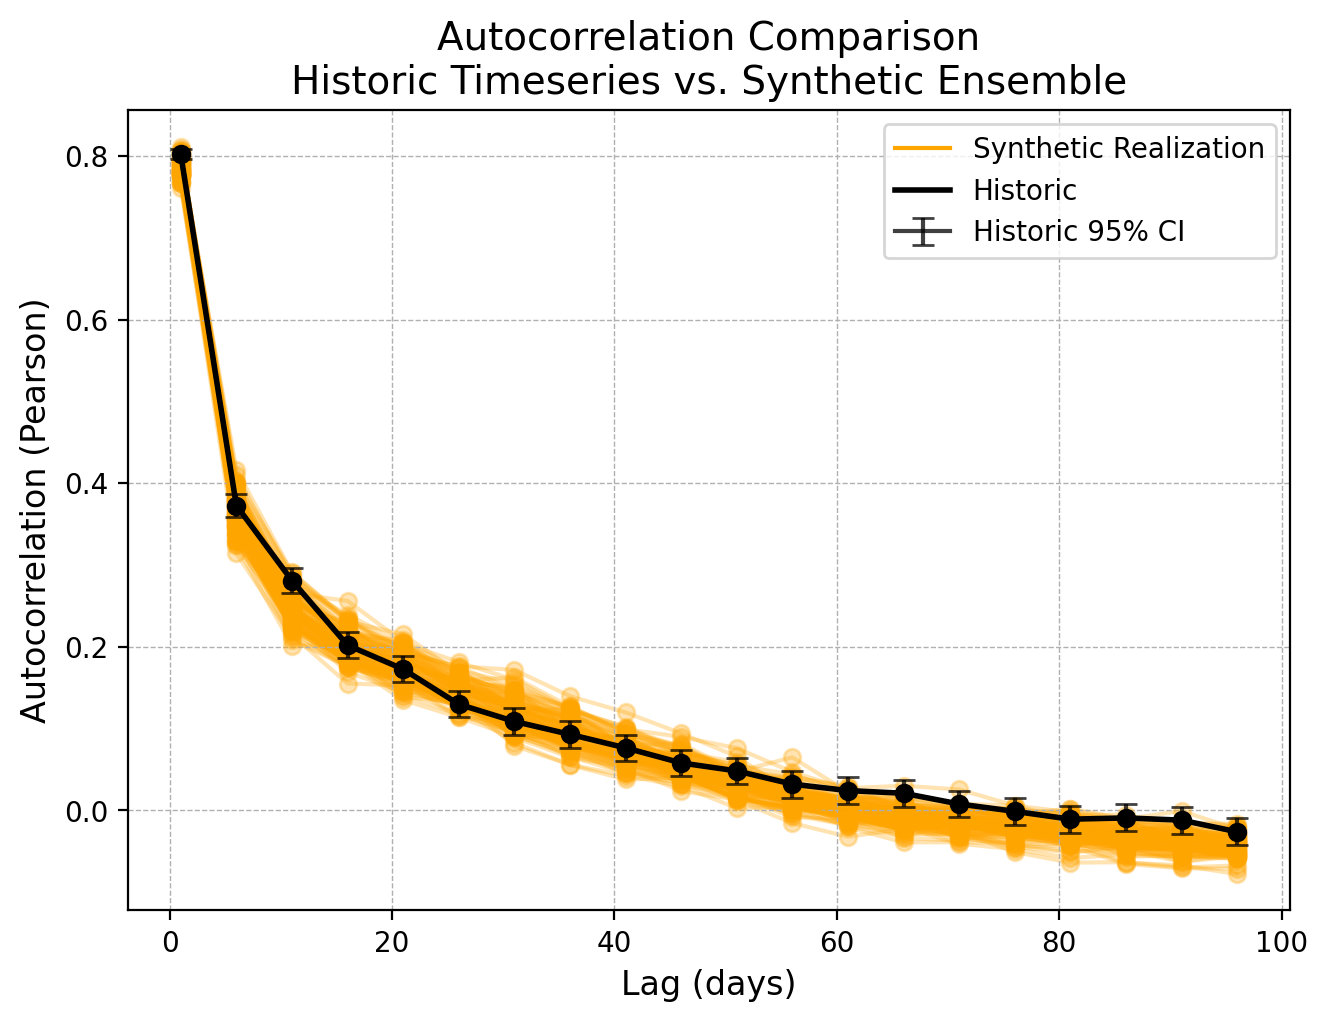

In [4]:
def plot_autocorrelation(Qh, Qs, lag_range, 
                         timestep = 'daily',
                         savefig = False, fig_dir = '.',
                         figsize=(7, 5), colors = ['black', 'orange'],
                         alpha = 0.3):
    """Plot autocorrelation of historic and synthetic flow over some range of lags.

    Args:
        Qh (pd.Series): Historic daily streamflow timeseries. Index must be pd.DatetimeIndex. 
        Qs (pd.DataFrame): Synthetic daily streamflow timeseries realizations. Each column is a unique realization. Index must be pd.DatetimeIndex.
        lag_range (iterable): A list or range of lag values to be used for autocorrelation calculation.
        
        timestep (str, optional): The timestep which data should be aggregated over. Defaults to 'daily'. Options are 'daily', 'weekly', or 'monthly'.
        savefig (bool, optional): Allows for png to be saved to fig_dir. Defaults to False.
        fig_dir (str, optional): Location of saved figure output. Defaults to '.' (working directory).
        figsize (tuple, optional): The figure size. Defaults to (4,4).
        colors (list, optional): List of two colors for historic and synthetic data respectively. Defaults to ['black', 'orange'].
        alpha (float, optional): The opacity of synthetic data. Defaults to 0.3.
    """
    
    ## Assertions
    assert(type(Qs) == pd.DataFrame), 'Synthetic streamflow should be type pd.DataFrame.'
    assert(type(Qh.index) == pd.DatetimeIndex), 'Historic streamflow (Qh) should have pd.DatatimeIndex.'
    assert(type(Qs.index) == pd.DatetimeIndex), 'Synthetic streamflow (Qh) should have pd.DatatimeIndex.'

    if timestep == 'monthly':
        Qh = Qh.resample('MS').sum()
        Qs = Qs.resample('MS').sum()
        time_label = 'months'
    elif timestep == 'weekly':
        Qh = Qh.resample('W-SUN').sum()
        Qs = Qs.resample('W-SUN').sum()
        time_label = f'weeks'
    elif timestep == 'daily':
        time_label = f'days'
        
    # Calculate autocorrelations
    autocorr_h = np.zeros(len(lag_range))
    confidence_autocorr_h = np.zeros((2, len(lag_range)))
    for i, lag in enumerate(lag_range):
        h_corr = pearsonr(Qh.values[:-lag], Qh.values[lag:])
        autocorr_h[i] = h_corr[0]
        confidence_autocorr_h[0,i] = h_corr[0] - h_corr.confidence_interval().low
        confidence_autocorr_h[1,i] = h_corr.confidence_interval().high - h_corr[0]
    
    autocorr_s = np.zeros((Qs.shape[1], len(lag_range)))
    for i, realization in enumerate(Qs.columns):
        autocorr_s[i] = [pearsonr(Qs[realization].values[:-lag], Qs[realization].values[lag:])[0] for lag in lag_range]


    ## Plotting
    fig, ax = plt.subplots(figsize=figsize, dpi=200)

    # Plot autocorrelation for each synthetic timeseries
    for i, realization in enumerate(Qs.columns):
        if i == 0:
            ax.plot(lag_range, autocorr_s[i], alpha=1, color = colors[1], label=f'Synthetic Realization')
        else:
            ax.plot(lag_range, autocorr_s[i], color = colors[1], alpha=alpha, zorder = 1)
        ax.scatter(lag_range, autocorr_s[i], alpha=alpha, color = 'orange', zorder = 2)

    # Plot autocorrelation for the historic timeseries
    ax.plot(lag_range, autocorr_h, color=colors[0], linewidth=2, label='Historic', zorder = 3)
    ax.scatter(lag_range, autocorr_h, color=colors[0], zorder = 4)
    ax.errorbar(lag_range, autocorr_h, yerr=confidence_autocorr_h, 
                color='black', capsize=4, alpha=0.75, label ='Historic 95% CI')

    # Set labels and title
    ax.set_xlabel(f'Lag ({time_label})', fontsize=12)
    ax.set_ylabel('Autocorrelation (Pearson)', fontsize=12)
    ax.set_title('Autocorrelation Comparison\nHistoric Timeseries vs. Synthetic Ensemble', fontsize=14)

    ax.legend(fontsize=10)
    ax.grid(True, linestyle='--', linewidth=0.5)
    plt.subplots_adjust(left=0.12, right=0.95, bottom=0.12, top=0.92)

    if savefig:
        plt.savefig(f'{fig_dir}/autocorrelation_plot_{timestep}.png', dpi=200, bbox_inches='tight')
    plt.show()
    return

## Usage
plot_autocorrelation(Qh, Qs, lag_range=range(1,100, 5), timestep='daily')

## Spatial Correlation

The `plot_spatial_correlation()` function generates a heatmap visualization of the Pearson correlation matrix for streamflow at different locations in both the historic and synthetic datasets.

The `plot_spatial_correlation()` function is different from the other three functions shown above, since it requires a set of timeseries data for multiple different locations.

Rather than providing a set of many different realizations for a single site we need to provide a single realization of synthetics across all sites of interest, with a timeseries for each site in each column. This new input is `Qs_i`, and must the same columns as `Qh` (they both must contain a timeseries for each location).

In [5]:
def plot_correlation(Qh, Qs_i,
                        timestep = 'daily',
                        savefig = False, fig_dir = '.',
                        figsize = (8,4), color_map = 'BuPu',
                        cbar_on = True):
    """Plots the side-by-side heatmaps of flow correlation between sites for historic and synthetic multi-site data.
    
    Args:
        Qh (pd.DataFrame): Historic daily streamflow timeseries at many different locations. The columns of Qh and Qs_i must match, and index must be pd.DatetimeIndex. 
        Qs (pd.DataFrame): Synthetic daily streamflow timeseries realizations. Each column is a unique realization. The columns of Qh and Qs_i must match, and index must be pd.DatetimeIndex.
        timestep (str, optional): The timestep which data should be aggregated over. Defaults to 'daily'. Options are 'daily', 'weekly', or 'monthly'.
        savefig (bool, optional): Allows for png to be saved to fig_dir. Defaults to False.
        fig_dir (str, optional): Location of saved figure output. Defaults to '.' (working directory).
        figsize (tuple, optional): The figure size. Defaults to (4,4).
        color_map (str, optional): The colormap used for the heatmaps. Defaults to 'BuPu.
        cbar_on (bool, optional): Indictor if the colorbar should be shown or not. Defaults to True.
    """
    
    ## Assertions
    assert(type(Qh) == type(Qs_i) and (type(Qh) == pd.DataFrame)), 'Both inputs Qh and Qs_i should be pd.DataFrames.'
    assert(np.mean(Qh.columns == Qs_i.columns) == 1.0), 'Historic and synthetic data should have same columns.'
    
    if timestep == 'monthly':
        Qh = Qh.resample('MS').sum()
        Qs_i = Qs_i.resample('MS').sum()
    elif timestep == 'weekly':
        Qh = Qh.resample('W-SUN').sum()
        Qs_i = Qs_i.resample('W-SUN').sum()
    
    ## Plotting
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=figsize, dpi = 250)
    
    # Heatmap of historic correlation
    h_correlation = np.corrcoef(Qh.values.transpose())
    sns.heatmap(h_correlation, ax = ax1, 
                square = True, annot = False,
                xticklabels = 5, yticklabels = 5, 
                cmap = color_map, cbar = False, vmin = 0, vmax = 1)

    # Synthetic correlation
    s_correlation = np.corrcoef(Qs_i.values.transpose())
    sns.heatmap(s_correlation, ax = ax2,
                square = True, annot = False,
                xticklabels = 5, yticklabels = 5, 
                cmap = color_map, cbar = False, vmin = 0, vmax = 1)
    
    for axi in (ax1, ax2):
        axi.set_xticklabels([])
        axi.set_yticklabels([])
    ax1.set(xlabel = 'Site i', ylabel = 'Site j', title = 'Historic Streamflow')
    ax2.set(xlabel = 'Site i', ylabel = 'Site j', title = 'Synthetic Realization')
    title_string = f'Pearson correlation across different streamflow locations\n{timestep.capitalize()} timescale\n'
        
    # Adjust the layout to make room for the colorbar
    if cbar_on:
        plt.tight_layout(rect=[0, 0, 0.9, 0.85])
        cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.6])  # [left, bottom, width, height]
        cbar = fig.colorbar(ax1.collections[0], cax=cbar_ax)
        cbar.set_label("Pearson Correlation")
    plt.suptitle(title_string, fontsize = 12)
    
    if savefig:
        plt.savefig(f'{fig_dir}/spatial_correlation_comparison_{timestep}.png', dpi = 250)
    plt.show()
    return

To use this function, I need to load a different `pd.DataFrame` containing synthetic timeseries at all of my study locations. I will also load the full set of historic streamflows at all locations (`Qh_df`)

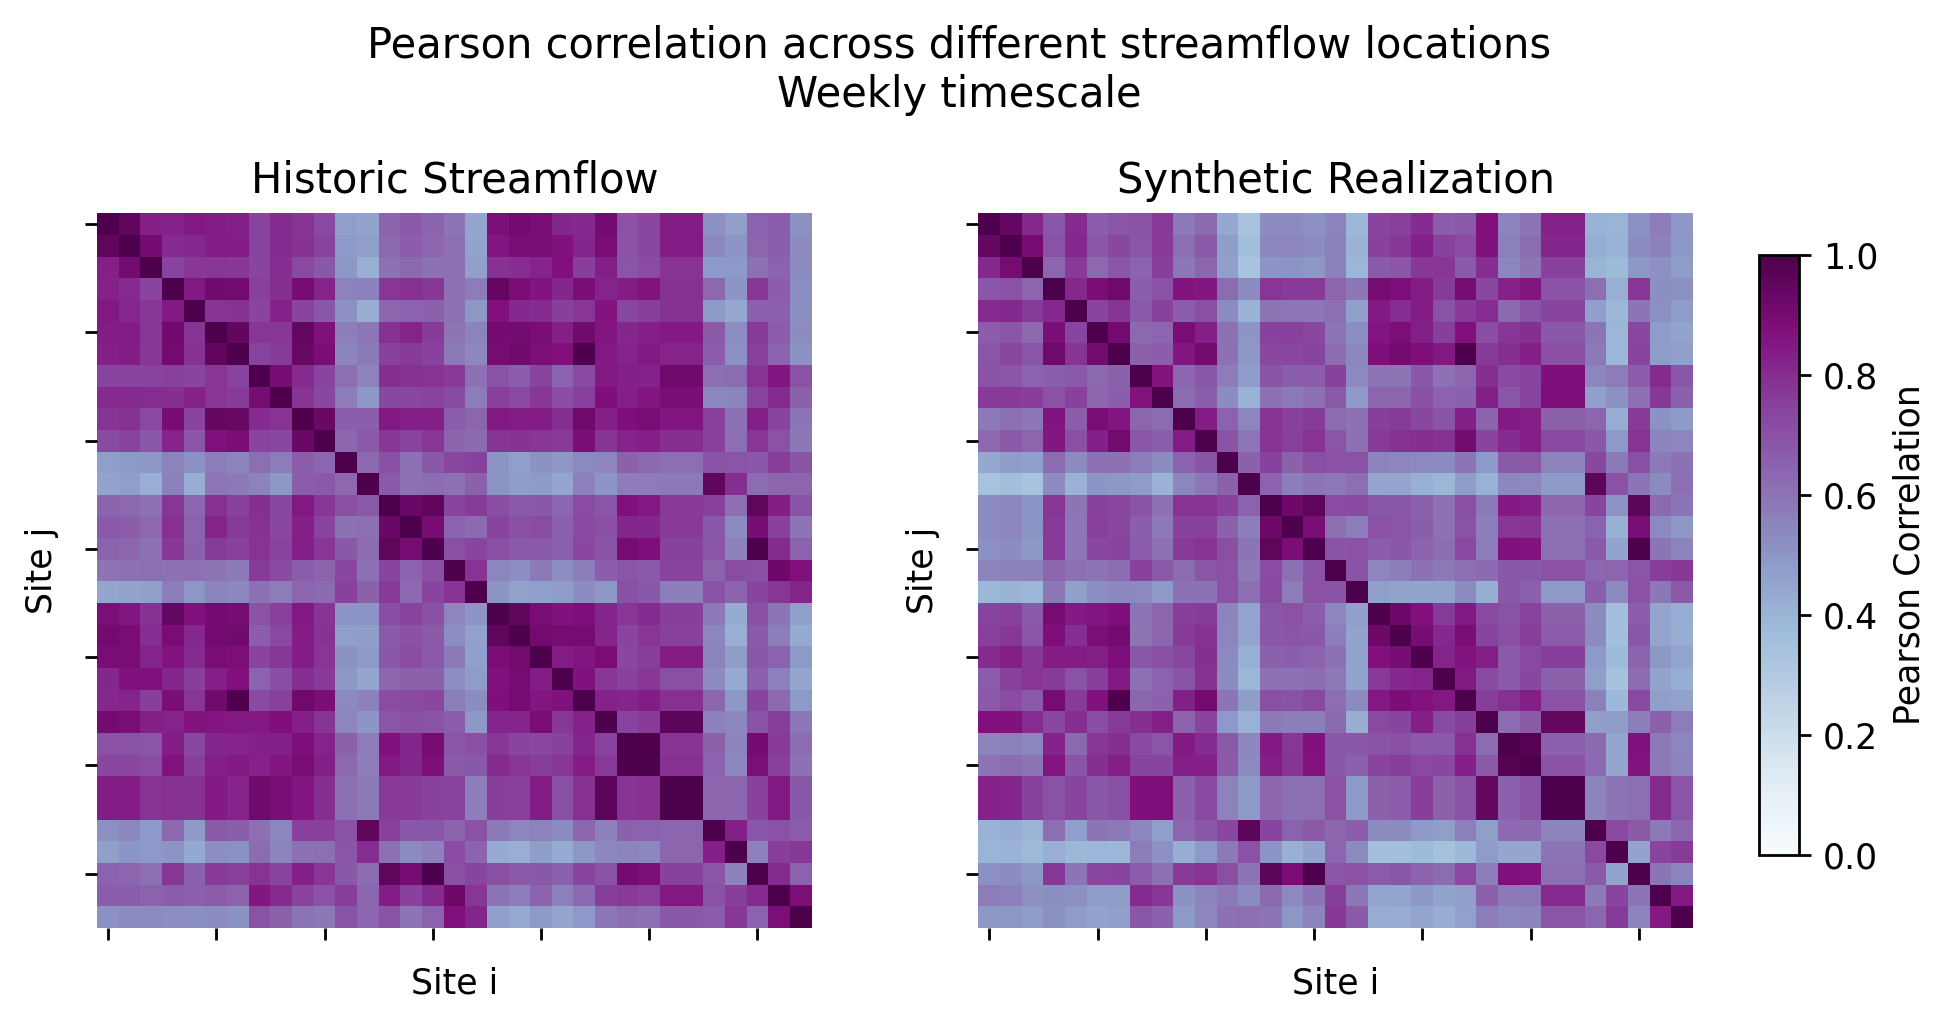

In [6]:
## Usage
single_synthetic_all_sites = pd.read_csv('./example_data/synthetic_streamflow_single_realization_all_sites.csv', sep=',', index_col=0, parse_dates=True)
Qh_df = pd.read_csv(f'./example_data/gage_flow_obs_pub.csv', sep=',', index_col=0, parse_dates=True).loc['1984-01-01':, :]
 
plot_correlation(Qh_df, single_synthetic_all_sites, timestep='weekly')

## References

[1] Kirsch, B. R., Characklis, G. W., & Zeff, H. B. (2013). Evaluating the impact of alternative hydro-climate scenarios on transfer agreements: Practical improvement for generating synthetic streamflows. Journal of Water Resources Planning and Management, 139(4), 396-406.

[2] Nowak, K., Prairie, J., Rajagopalan, B., & Lall, U. (2010). A nonparametric stochastic approach for multisite disaggregation of annual to daily streamflow. Water Resources Research, 46(8).